In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.optimize as so
import scipy.stats as ss
import copy
import json
import seaborn as sns
import matplotlib

from tqdm import tqdm 
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Import data

In [2]:
fd_filename = "/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/raw/fd_shape.tsv"
fd_data = pd.read_csv(fd_filename, sep='\t',names=["station", "right_end_occ", "mean_flow", "sd_flow", "number_observed"])

m25_filename = "/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/raw/m25_data.csv"
m25_data = pd.read_csv(m25_filename)

# Process data

In [3]:
m25_data = m25_data.sort_values('density')

In [4]:
rho = m25_data.density.values
q = m25_data.flow.values
log_q = np.log(q)

# Pretty visualisations

In [ ]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [ ]:
param_names = [r'$Z$',r'$u$',r'$\rho_j$',r'$\omega$']
fixed_params = [100.0,3.0,100.0,1.0]
den = np.linspace(0,100,100)
def simulate(r,p):
    return p[0]*( ((p[1]/p[2])*r)**(-p[3]) + (1-(r/p[2]))**(-p[3]) )**(-1/p[3])

data = pd.DataFrame(data=den,columns=['density'])
fixed_params[-1] = 0.1
data['w0_1'] = simulate(den,fixed_params)
fixed_params[-1] = 1
data['w1'] = simulate(den,fixed_params)
fixed_params[-1] = 5
data['w5'] = simulate(den,fixed_params)
fixed_params[-1] = 10
data['w10'] = simulate(den,fixed_params)
fixed_params[-1] = 50
data['w50'] = simulate(den,fixed_params)
fixed_params[-1] = 60
data['w100'] = simulate(den,fixed_params)

In [ ]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.lineplot(data = data, x = "density", y = "w1", label='$\omega=1$')
ax = sns.lineplot(data = data, x = "density", y = "w5", label='$\omega=5$')
ax = sns.lineplot(data = data, x = "density", y = "w10", label='$\omega=10$')
ax = sns.lineplot(data = data, x = "density", y = "w100", label='$\omega=100$')
ax.set_xlabel('Density $k$', fontsize=20)
ax.set_ylabel('Flow $q$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(loc='upper right', prop={'size': 15})
arrow = u'$\u2193$'
ax.arrow(30, 45, -5, 15, shape='full', lw=1, length_includes_head=True, head_width=1, color='black', linestyle="dashed")
ax.annotate(r"$\omega$ increases",(29,50),fontsize="20")
plt.tight_layout()    
plt.savefig('../data/figures/delcastillos_fd.png',dpi=300)

## Visualising DelCastillo's data

In [5]:
root = '/Users/Yannis/code/probabilistic_traffic_flow_modelling/'
output_dir = root+"data/output/experiment_data/"

In [6]:
def daganzos(r,p):
    return (p[0]/p[1])*r * (r < p[1])*1 + p[0]*(p[2]-r)/(p[2]-p[1]) * (r >= p[1])*1
def log_daganzos(r,p):
    return (np.log(p[0])-np.log(p[1])+np.log(r)) * (r < p[1])*1 + (np.log(p[0])+np.log(p[2]-r)-np.log(p[2]-p[1])) * (r >= p[1])*1

daganzos_params = [130, 120, 600, 0.025940885278086342]
map_params = [127.27044340191402, 5.643857224897048, 1194.060941272785, 0.025940885278086342]

In [7]:
data_id = "m25_data_fd_n392"
data_fd = "m25_data"
inference_fd = "northwesterns"
experiment_type = "n392"
sensitivity = "regular"

fds = ['greenshields','daganzos','delcastillos','greenbergs','underwoods','northwesterns','newells','wangs','smulders','deromphs']

In [8]:
r2s_log = {}
r2s = {}
for fd in fds:
    
    pp_file = output_dir + data_id+'/'+f'grwmh_{fd}_model_{data_fd}_learn_noise_{experiment_type}_{sensitivity}_prior'
    posterior_predictive = np.loadtxt(pp_file+'/posterior_predictive_mean.txt')
    
    log_q_hat = posterior_predictive
    log_q_bar = np.sum(log_q)/len(log_q)
    log_ssres = np.sum((log_q_hat-log_q)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    log_sstot = np.sum((log_q - log_q_bar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    
    r2_log = 1 - log_ssres/log_sstot
    r2s_log[str(fd)] = float(r2_log)
#     print('r2_log',r2_log)

    q_hat = np.exp(posterior_predictive)
    q_bar = np.sum(q)/len(q)          # or sum(y)/len(y)
    ssres = np.sum((q_hat-q)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((q - q_bar)**2)    # or sum([ (yi - ybar)**2 for yi in y])

    r2 = 1 - ssres / sstot
#     print('r2',r2)
    r2s[str(fd)] = float(r2)

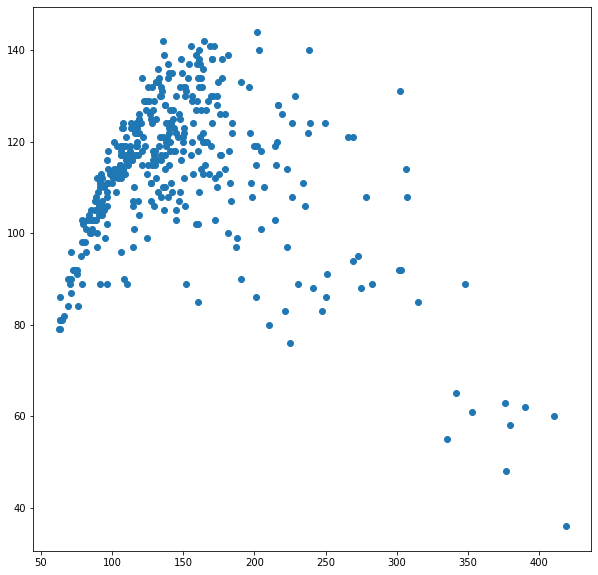

In [10]:
plt.figure(figsize=(10,10))
# plt.scatter(rho,log_q)
# plt.plot(rho,log_daganzos(rho,daganzos_params),color='red')
plt.scatter(rho,q)
# plt.plot(rho,daganzos(rho,daganzos_params),color='red')

# Export data

In [ ]:
np.savetxt('/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/output/fundamental_diagram_data/m25_data_n392/q.txt',m25_data.flow)
np.savetxt('/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/output/fundamental_diagram_data/m25_data_n392/log_q.txt',np.log(m25_data.flow))
np.savetxt('/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/output/fundamental_diagram_data/m25_data_n392/rho.txt',m25_data.density)